In [2]:
import matplotlib.pyplot as plt

from turtle import forward
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

from torch.utils.data import Dataset, DataLoader

In [1]:
1

1

In [ ]:
import matplotlib.pyplot as plt

def plot_specgram(waveform, sample_rate, title="Spectrogram", show_in_notebook=True, file_path=None):
    # Convert to NumPy for Matplotlib
    waveform = waveform.numpy()
    channels, frames = waveform.shape

    fig, axes = plt.subplots(channels, 1, figsize=(10, 4 if channels == 1 else 3*channels))

    # axes is ndarray when channels>1; make it iterable in all cases
    axes = axes if isinstance(axes, (list, tuple, np.ndarray)) else [axes]

    for c, ax in enumerate(axes):
        ax.specgram(waveform[c], Fs=sample_rate)
        ax.set_ylabel(f"Channel {c+1}")
    fig.suptitle(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")

    if file_path:
        plt.savefig(file_path, dpi=150, bbox_inches="tight")
    
    if show_in_notebook:
        plt.show()
    
    plt.close(fig)



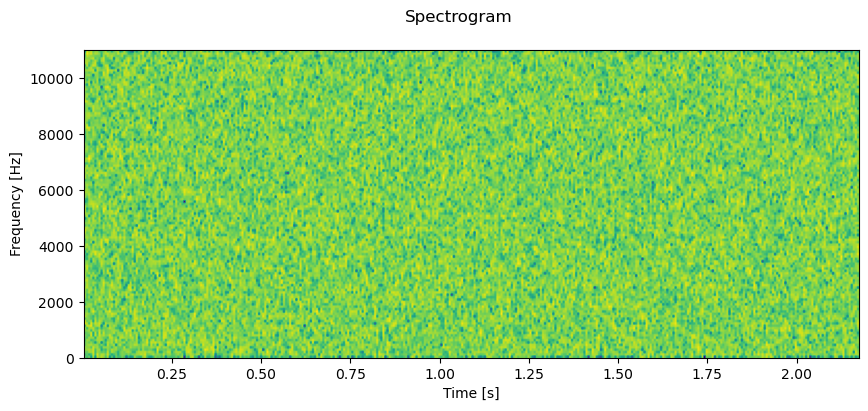

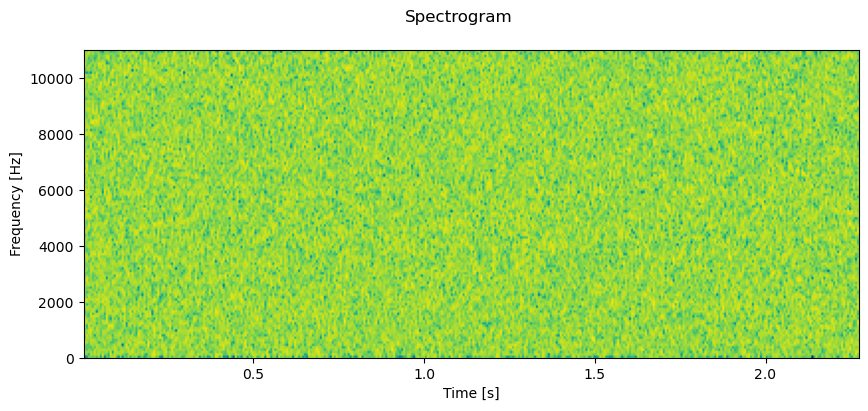

In [42]:
import torchaudio, random

data_path = '../data/hb/'

unl = 'unlabelled'
unlab = Path(data_path,unl)
random_unlabel = random.choice(list(unlab.glob('*')))


waveform, sr = torchaudio.load(random_unlabel.resolve().as_uri(), backend="ffmpeg")
plot_specgram(waveform, sr)

unl = 'murmur'
unlab = Path(data_path,unl)
random_unlabel = random.choice(list(unlab.glob('*')))
waveform, sr = torchaudio.load(random_unlabel.resolve().as_uri(), backend="ffmpeg")
plot_specgram(waveform, sr)


# plot_specgram(waveform, sr, file_path="random_unlabel.png")  

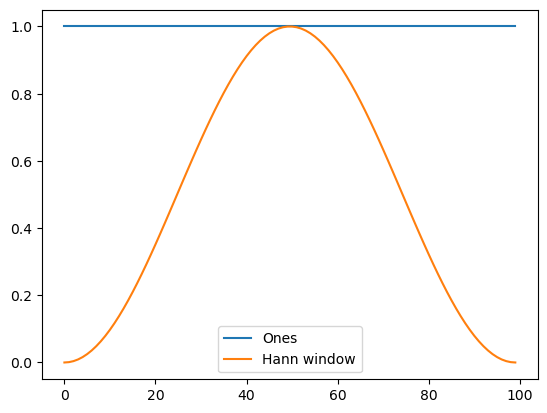

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal.windows import hann

n = 100
window_func = hann(n)
ones = [1]*n


plt.plot(ones, label="Ones")
plt.plot(window_func, label="Hann window")

plt.legend()
plt.show()

In [45]:
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time
from scipy.fft import fft

def custom_spectrogram(audio_array, sample_rate, global_v, window_size=256, overlap_percent=50, 
                      title="Custom Spectrogram", show_plot=True):
    
    # Calculate overlap in samples
    overlap_samples = int(window_size * overlap_percent / 100)
    hop_length = window_size - overlap_samples
    
    # Calculate number of windows
    num_samples = len(audio_array)
    num_windows = (num_samples - overlap_samples) // hop_length
    
    # Create Hanning window for tapering
    window_func = hann(window_size)
    
    # Initialize spectrogram matrix
    # Frequency bins: window_size//2 + 1 (positive frequencies only)
    freq_bins = window_size // 2 + 1
    spectrogram = np.zeros((freq_bins, num_windows))
    
    # Perform STFT
    for i in range(num_windows):
        # Extract windowed segment
        start_idx = i * hop_length
        end_idx = start_idx + window_size
        
        if end_idx <= num_samples:
            # Get audio segment and apply window function
            segment = audio_array[start_idx:end_idx].copy() 
            clear_output(wait=True)
            
            
            plt.plot(segment, label="Input")
            segment *= window_func
            plt.plot(segment, label="Hanned")

            
            # Compute FFT
            fft_result = fft(segment)
            global_v['fft'] = [fft_result]
            print(f"FFT: \t {len(fft_result)}")
            
            # Take magnitude of positive frequencies only
            magnitude = np.abs(fft_result[:freq_bins])
            print(f"magnitude: \t {len(magnitude)}")
            global_v['magnitude'] = [magnitude]
            plt.legend()
            plt.show()
            time.sleep(2)
            # Store in spectrogram matrix
            spectrogram[:, i] = magnitude
    
    # Convert to dB scale (log scale)
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    spectrogram_db = 20 * np.log10(spectrogram + epsilon)
    
    # Create frequency and time axes
    frequencies = np.fft.fftfreq(window_size, 1/sample_rate)[:freq_bins]
    times = np.arange(num_windows) * hop_length / sample_rate
    
    if show_plot:
        # Plot the spectrogram
        plt.figure(figsize=(12, 8))
        
        # Create heatmap
        plt.imshow(spectrogram_db, 
                   aspect='auto', 
                   origin='lower',
                   extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
                   cmap='viridis',
                   interpolation='nearest')
        
        plt.colorbar(label='Magnitude (dB)')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title(f'{title}\nWindow: {window_size}, Overlap: {overlap_percent}%')
        plt.tight_layout()
        plt.show()
    
    return spectrogram_db, frequencies, times

FFT: 	 256
magnitude: 	 129


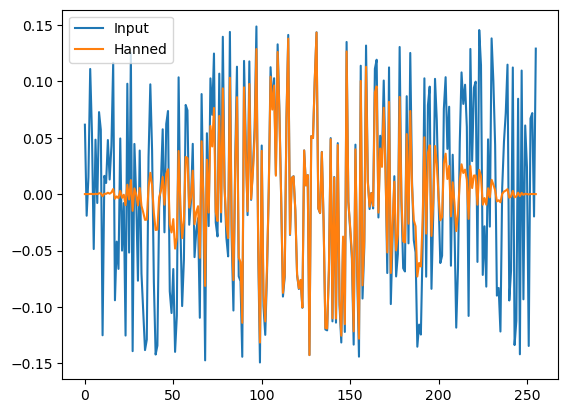

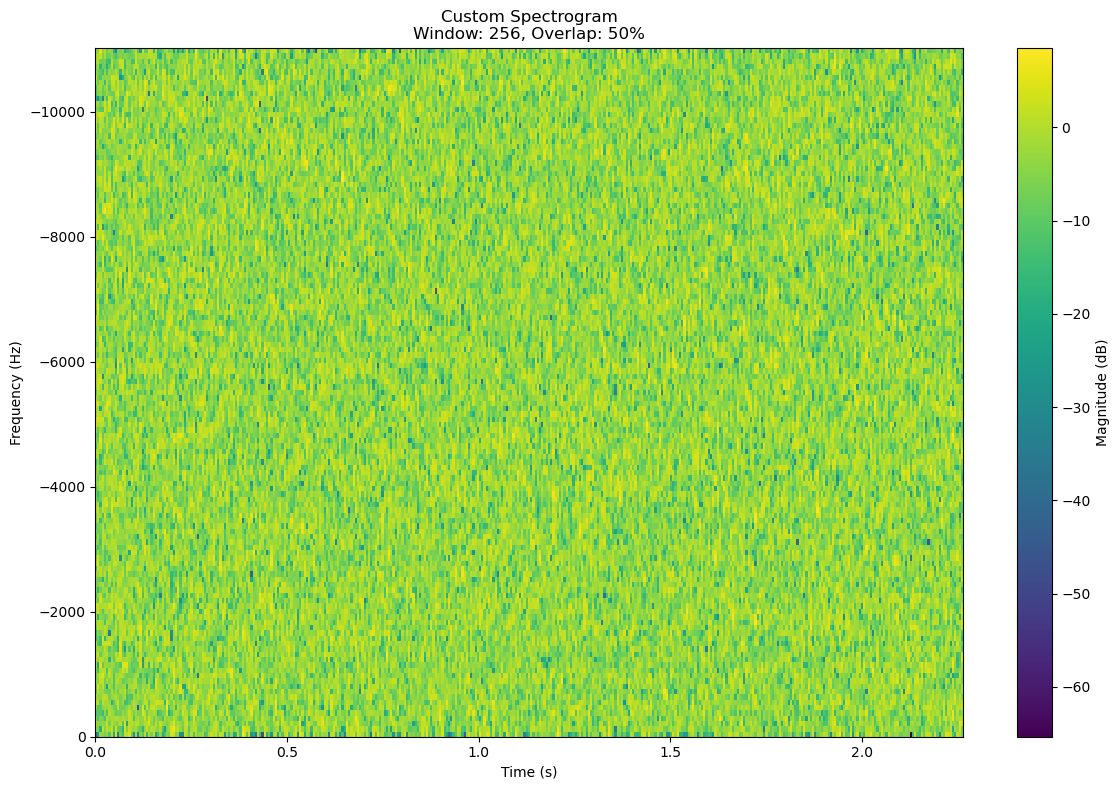

(array([[-3.73574428e+01, -2.45444379e+01, -2.77210523e+00, ...,
          2.08857046e+00, -1.63524587e-01, -6.39455382e+00],
        [-2.88729495e+00, -5.61189156e+00, -1.86287648e+01, ...,
         -4.41889401e+00,  4.20860253e+00, -7.08533363e+00],
        [-2.33369766e-02, -3.40374547e+00, -5.10526704e+00, ...,
         -5.66148441e+00,  5.83704882e+00,  1.07392849e+00],
        ...,
        [ 8.92000959e-01, -9.38278569e-01, -7.17857822e+00, ...,
         -2.22856949e+00, -1.11283378e+00, -6.47975626e+00],
        [-4.68138690e-01, -6.43891278e-01,  2.13391234e+00, ...,
         -4.38641836e+00, -3.07078724e+00, -1.23608914e+01],
        [-3.05175526e+00, -5.24880540e+00,  6.01259695e+00, ...,
         -3.80573872e+00, -6.70646663e+00, -4.96912560e+00]]),
 array([     0.       ,     86.1328125,    172.265625 ,    258.3984375,
           344.53125  ,    430.6640625,    516.796875 ,    602.9296875,
           689.0625   ,    775.1953125,    861.328125 ,    947.4609375,
          103

In [46]:
global_v = {}
print(waveform.reshape(-1).shape)
print(sr)
custom_spectrogram(waveform.reshape(-1).numpy(), sr, global_v)

In [4]:
import torch
print(torch.version.cuda)        # CUDA version PyTorch was built with
print(torch.backends.cudnn.version())  # cuDNN version (if available)
print(torch.cuda.is_available())      # whether CUDA runtime is accessible

import torchaudio
print(torchaudio.list_audio_backends())

12.4
90100
True
['ffmpeg', 'sox', 'soundfile']
